In [87]:
# import necessary python libraries;

import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras as ks
from tensorflow.estimator import LinearRegressor

In [88]:
import warnings
warnings.filterwarnings('ignore')

In [89]:
print(tf.__version__) # i'm using tensorflow 2.4.0 

2.4.0-rc0


In [90]:
from tensorflow.python.compiler.mlcompute import mlcompute

In [91]:
mlcompute.set_mlc_device(device_name='cpu')

In [92]:
data = pd.read_csv('Auto.csv') # load in the dataset

In [93]:
data.head() # we are going to try and predict miles per gallon based on the other features

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [94]:
data.shape # check dimensionality of the data

(397, 9)

In [95]:
len(data.name.unique())

304

In [96]:
data = data.drop(['name'], axis=1) # drop name for now because it has too many unique values, and is a categorical

In [97]:
# from https://www.tensorflow.org/tutorials/keras/regression; we see that origin is actually categorical and so we 
# one hot encode it

data['origin'] = data['origin'].map({1: 'united states', 2: 'europe', 3: 'japan'})
data = pd.get_dummies(data, columns=['origin'], prefix='', prefix_sep='')
data.tail()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,europe,japan,united states
392,27.0,4,140.0,86,2790,15.6,82,0,0,1
393,44.0,4,97.0,52,2130,24.6,82,1,0,0
394,32.0,4,135.0,84,2295,11.6,82,0,0,1
395,28.0,4,120.0,79,2625,18.6,82,0,0,1
396,31.0,4,119.0,82,2720,19.4,82,0,0,1


In [98]:
data.isnull().sum()

mpg              0
cylinders        0
displacement     0
horsepower       0
weight           0
acceleration     0
year             0
europe           0
japan            0
united states    0
dtype: int64

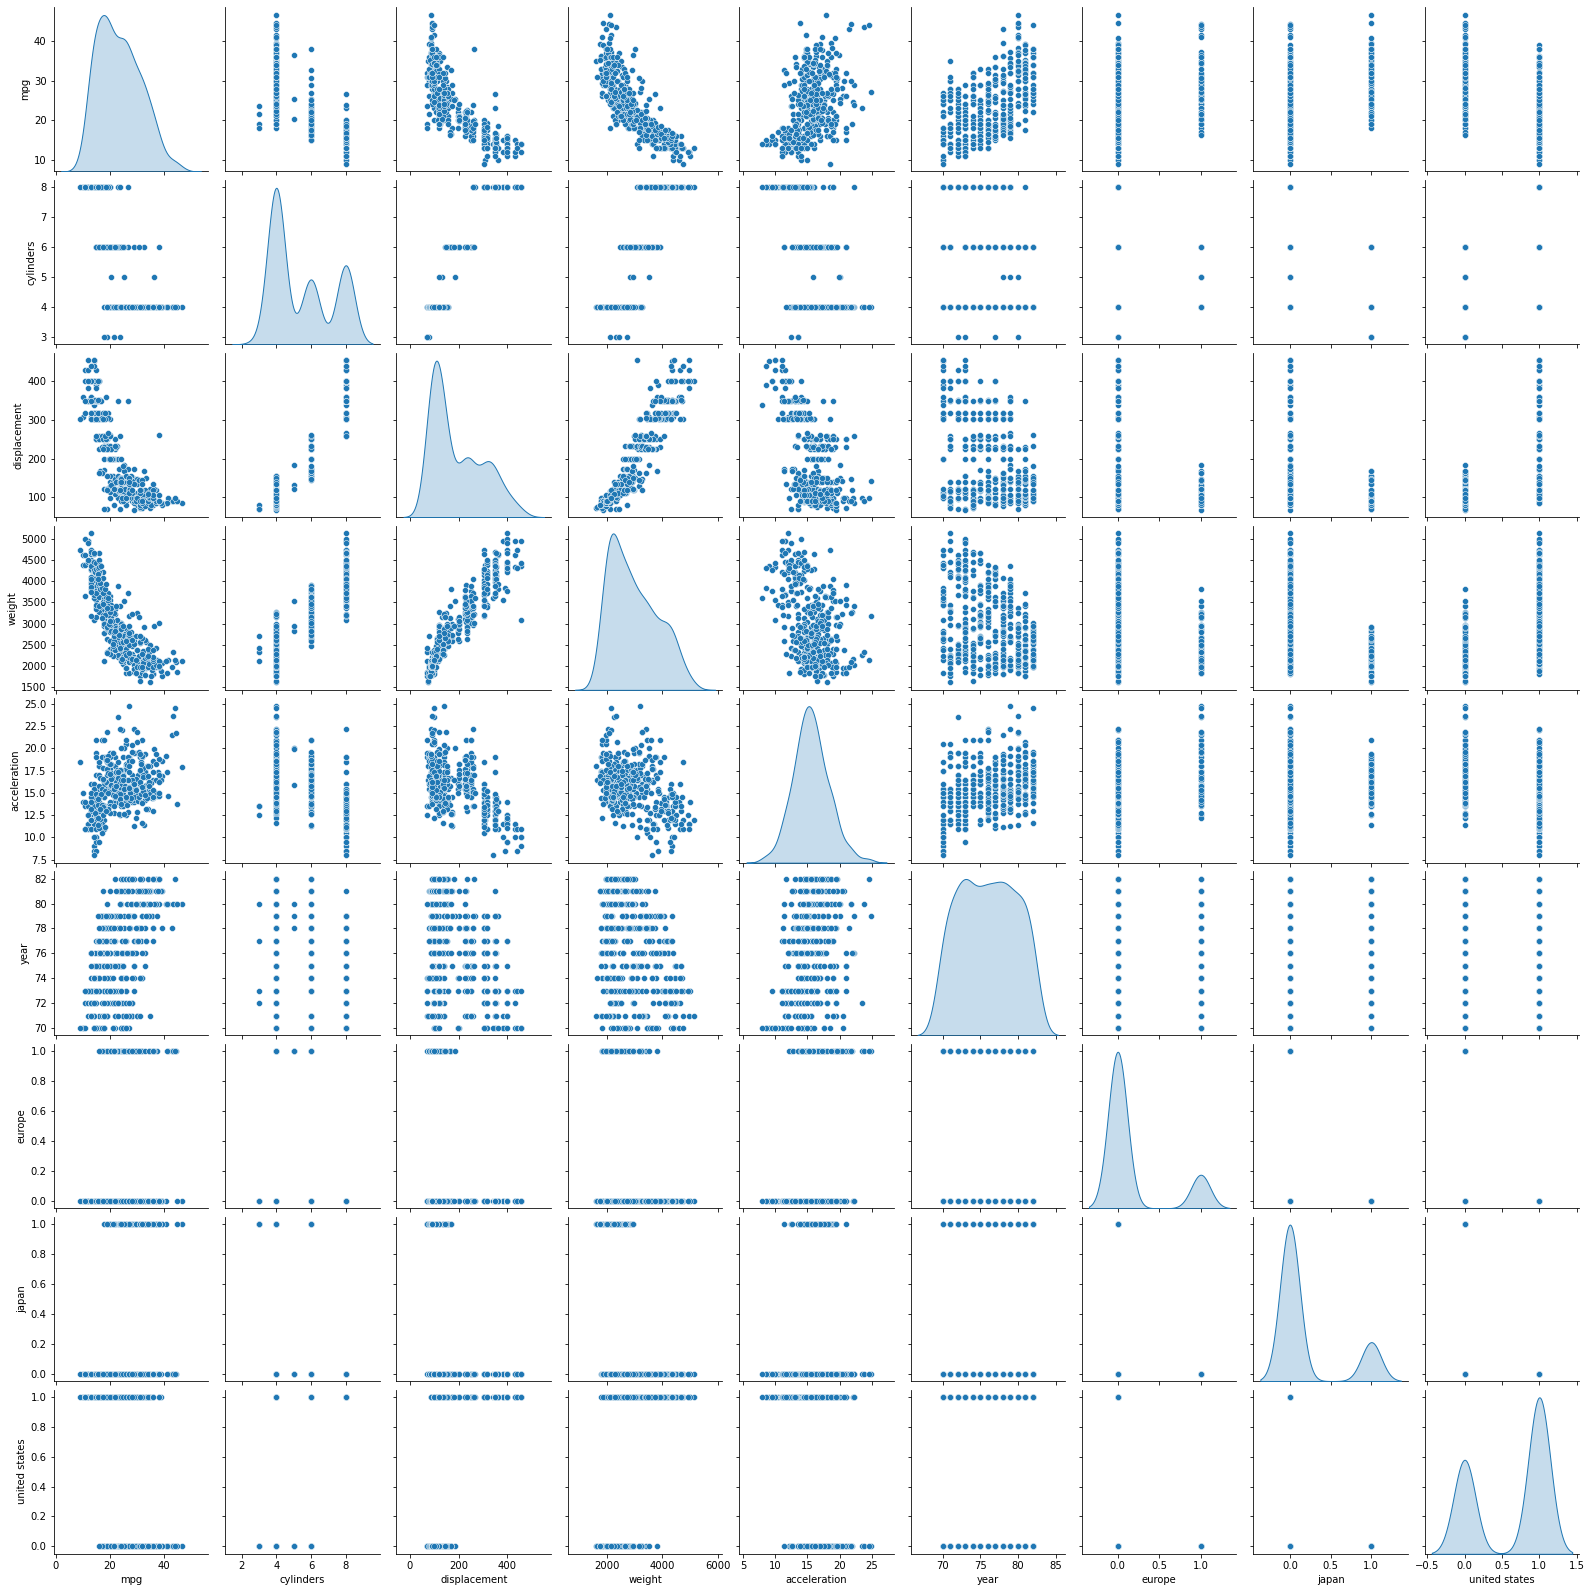

In [99]:
sb.pairplot(data, diag_kind='kde') # check relationship between variables

In [104]:
data.describe().transpose() # data statistics

,count,mean,std,min,25%,50%,75%,max
mpg,397.0,23.515869,7.825804,9.0,17.5,23.0,29.0,46.6
cylinders,397.0,5.458438,1.701577,3.0,4.0,4.0,8.0,8.0
displacement,397.0,193.532746,104.379583,68.0,104.0,146.0,262.0,455.0
weight,397.0,2970.261965,847.904119,1613.0,2223.0,2800.0,3609.0,5140.0
acceleration,397.0,15.555668,2.749995,8.0,13.8,15.5,17.1,24.8
year,397.0,75.994962,3.690005,70.0,73.0,76.0,79.0,82.0
europe,397.0,0.176322,0.381575,0.0,0.0,0.0,0.0,1.0
japan,397.0,0.198992,0.399746,0.0,0.0,0.0,0.0,1.0
united states,397.0,0.624685,0.484815,0.0,0.0,1.0,1.0,1.0


In [105]:
# split the dataset into 20% test and 80% train
np.random.seed(10)
msk = np.random.rand(len(data)) < 0.8
train = data[msk]
test = data[~msk]

X_train = train.loc[:,['cylinders', 'displacement', 'weight', 'acceleration', 'year', 'europe', 'japan', 'united states']]
Y_train = train['mpg']

X_test = test.loc[:,['cylinders', 'displacement', 'weight', 'acceleration', 'year', 'europe', 'japan', 'united states']]
Y_test = test['mpg']

In [106]:
X_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cylinders,324.0,5.543210,1.729721,3.0,4.00,4.5,8.000,8.0
displacement,324.0,198.262346,107.527298,68.0,104.75,153.0,302.000,455.0
weight,324.0,3000.021605,856.629671,1613.0,2242.25,2822.5,3654.250,5140.0
acceleration,324.0,15.512037,2.837368,8.5,13.50,15.5,17.125,24.8
year,324.0,75.969136,3.735733,70.0,73.00,76.0,79.000,82.0
europe,324.0,0.179012,0.383956,0.0,0.00,0.0,0.000,1.0
japan,324.0,0.194444,0.396385,0.0,0.00,0.0,0.000,1.0
united states,324.0,0.626543,0.484470,0.0,0.00,1.0,1.000,1.0


In [107]:
X_test.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cylinders,73.0,5.082192,1.525282,4.0,4.0,4.0,6.0,8.0
displacement,73.0,172.541096,86.640932,79.0,98.0,134.0,232.0,400.0
weight,73.0,2838.178082,800.331777,1755.0,2150.0,2635.0,3459.0,4746.0
acceleration,73.0,15.749315,2.330422,8.0,14.5,15.5,17.0,21.0
year,73.0,76.109589,3.502228,70.0,73.0,76.0,79.0,82.0
europe,73.0,0.164384,0.373188,0.0,0.0,0.0,0.0,1.0
japan,73.0,0.219178,0.416552,0.0,0.0,0.0,0.0,1.0
united states,73.0,0.616438,0.489618,0.0,0.0,1.0,1.0,1.0


In [108]:
def norm(x): # normalize the data for predictions
    stats = x.describe()
    stats = stats.transpose()
    return (x - stats['mean']) / stats['std']

normed_train_features = norm(X_train)
normed_test_features = norm(X_test)

In [109]:
normed_train_features.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cylinders,324.0,6.579099e-17,1.0,-1.470301,-0.892173,-0.603109,1.420339,1.420339
displacement,324.0,-8.772133e-17,1.0,-1.211435,-0.869661,-0.420938,0.964756,2.387651
weight,324.0,2.193033e-17,1.0,-1.619161,-0.884596,-0.207233,0.763724,2.498137
acceleration,324.0,3.508853e-16,1.0,-2.471317,-0.709121,-0.004242,0.568471,3.273443
year,324.0,-1.052656e-15,1.0,-1.597849,-0.794793,0.008262,0.811317,1.614372
europe,324.0,-2.193033e-17,1.0,-0.466232,-0.466232,-0.466232,-0.466232,2.138236
japan,324.0,8.772133e-17,1.0,-0.490545,-0.490545,-0.490545,-0.490545,2.032258
united states,324.0,1.096517e-17,1.0,-1.293255,-1.293255,0.770856,0.770856,0.770856


In [110]:
normed_test_features.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cylinders,73.0,-1.885858e-16,1.0,-0.709503,-0.709503,-0.709503,0.601730,1.912964
displacement,73.0,4.106304e-17,1.0,-1.079641,-0.860345,-0.444837,0.686268,2.625305
weight,73.0,-1.627313e-16,1.0,-1.353411,-0.859866,-0.253867,0.775706,2.383789
acceleration,73.0,1.055472e-15,1.0,-3.325284,-0.536090,-0.106983,0.536677,2.253105
year,73.0,9.490126e-16,1.0,-1.744486,-0.887889,-0.031291,0.825306,1.681904
europe,73.0,-1.064597e-17,1.0,-0.440484,-0.440484,-0.440484,-0.440484,2.239129
japan,73.0,5.931328e-17,1.0,-0.526172,-0.526172,-0.526172,-0.526172,1.874486
united states,73.0,-4.866731e-17,1.0,-1.259018,-1.259018,0.783389,0.783389,0.783389


In [111]:
#tensor pipeline

def feed_input(features_dataframe, target_dataframe, num_of_epochs=10, shuffle=True, batch_size=16):
    def input_feed_function():
        dataset = tf.data.Dataset.from_tensor_slices ((dict(features_dataframe), target_dataframe))
        if shuffle:
            dataset = dataset.shuffle(400)
        dataset = dataset.batch(batch_size).repeat(num_of_epochs)
        return dataset
    return input_feed_function

In [128]:
train = feed_input(normed_train_features, Y_train)
train_feed_input_testing = feed_input(normed_train_features, Y_train, num_of_epochs=1, shuffle=False)
test = feed_input(normed_test_features, Y_test, num_of_epochs=1, shuffle=False)

In [129]:
feat_columns = [tf.feature_column.numeric_column(m) for m in X_train.columns]

In [130]:
feat_columns

[NumericColumn(key='cylinders', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='displacement', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='weight', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='acceleration', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='year', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='europe', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='japan', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='united states', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

In [131]:
linear_model = LinearRegressor(feature_columns=feat_columns, optimizer='RMSProp')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/ws/xmz4q2tx6bj6qcjpcy0wlvbc0000gn/T/tmpg4wim2wo', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [132]:
linear_model.train(train) # train the linear model

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/ws/xmz4q2tx6bj6qcjpcy0wlvbc0000gn/T/tmpg4wim2wo/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 626.58997, step = 0
INFO:tensorflow:global_step/sec: 1051.72
INFO:tensorflow:loss = 42.58281, step = 100 (0.095 sec)
INFO:tensorflow:global_step/sec: 2077.84
INFO:tensorflow:loss = 9.502612, step = 200 (0.048 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 210...
INFO:tensorflow:Saving checkpoints for 210 into /var/folders/ws/xmz4q2tx6bj6qcjpcy0wlvbc0000gn/T/tmpg4wim2wo/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving ch

In [133]:
test_predictions = linear_model.predict(test)
train_predictions = linear_model.predict(train_feed_input_testing)

In [134]:
train_predictions_series = pd.Series([p['predictions'][0] for p in train_predictions])
test_predictions_series = pd.Series([p['predictions'][0] for p in test_predictions])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/ws/xmz4q2tx6bj6qcjpcy0wlvbc0000gn/T/tmpg4wim2wo/model.ckpt-210
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/ws/xmz4q2tx6bj6qcjpcy0wlvbc0000gn/T/tmpg4wim2wo/model.ckpt-210
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [135]:
test_predictions_df = pd.DataFrame(test_predictions_series, columns=['predictions']) 
train_predictions_df = pd.DataFrame(train_predictions_series, columns=['predictions'])

In [136]:
#test_predictions_df

In [137]:
Y_test.reset_index(drop=True, inplace=True)
test_predictions_df.reset_index(drop=True, inplace=True)

Y_train.reset_index(drop=True, inplace=True)
train_predictions_df.reset_index(drop=True, inplace=True)

In [138]:
test_labels_with_predictions_df = pd.concat([Y_test, test_predictions_df], axis=1) # test data predictions
train_labels_with_predictions_df = pd.concat([Y_train, train_predictions_df], axis=1)

In [139]:
test_labels_with_predictions_df

,mpg,predictions
0,14.0,11.566052
1,24.0,27.321060
2,27.0,27.505625
3,28.0,22.064770
4,25.0,24.692251
...,...,...
68,33.0,26.489521
69,32.9,29.608280
70,31.6,31.490524
71,32.0,31.420414


In [140]:
def calculate_errors_and_r2(y_true, y_pred):
    mean_squared_err = sum((y_true - y_pred)**2)/len(y_true) # mean squared error
    root_mean_squared_err = np.sqrt(mean_squared_err)
    tot_rss = sum((np.mean(y_true) - y_true)**2)
    rss = sum((y_true - y_pred)**2)
    r2 = round((1 - (rss/tot_rss))*100,0) # amount of variance in response expalained by predictors
    return mean_squared_err, root_mean_squared_err, r2

In [141]:
#model matrics
train_mean_squared_error, train_root_mean_squared_error, train_r2_score_percentage = calculate_errors_and_r2(Y_train, train_predictions_series)
test_mean_squared_error, test_root_mean_squared_error, test_r2_score_percentage = calculate_errors_and_r2(Y_test, test_predictions_series)

print('Training Data Mean Squared Error = ', train_mean_squared_error)
print('Training Data Root Mean Squared Error = ', train_root_mean_squared_error)
print('Training Data R2 = ', train_r2_score_percentage)
print()
print('Test Data Mean Squared Error = ', test_mean_squared_error)
print('Test Data Root Mean Squared Error = ', test_root_mean_squared_error)
print('Test Data R2 = ', test_r2_score_percentage) 

Training Data Mean Squared Error =  20.47339287537852
Training Data Root Mean Squared Error =  4.524753349673164
Training Data R2 =  68.0

Test Data Mean Squared Error =  18.51742292934662
Test Data Root Mean Squared Error =  4.30318753127802
Test Data R2 =  64.0


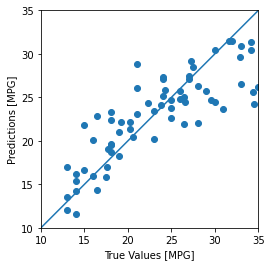

In [142]:
a = plt.axes(aspect='equal')
plt.scatter(Y_test, test_labels_with_predictions_df.predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [10, 35]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [127]:
# model does poorly in predicting larger values of MPG